In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import matplotlib  as mpl
import h5py
import matplotlib.colors as colors
from tqdm import tqdm
from scipy import stats
import cmasher as cmr
import seaborn as sns
import warnings
import multiprocessing as mp
from functools import partial
from tqdm import tqdm

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from matplotlib.colors import Normalize

import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

from matplotlib.colors import LogNorm


In [57]:
def Gal_inf (ID,Snap):

    file_path = f'/virgotng/universe/IllustrisTNG/TNG50-1/output/snapdir_{Snap:03d}/snap_{Snap:03d}.0.hdf5'
    
    with h5py.File(file_path, 'r') as f:
        header = dict( f['Header'].attrs.items())
        
    z = header['Redshift']

    scaling_factor = 1.0 / (1+z)

    hubble_param = header['HubbleParam']
    H0 = hubble_param*100
    Omega_lamb = header['OmegaLambda']
    Omega_baryon = header['OmegaBaryon']
    Omega_0 = header['Omega0']


    basePath = "/virgotng/universe/IllustrisTNG/TNG50-1/output"

    Subhalo = il.groupcat.loadSingle(basePath,Snap, subhaloID = ID)

    Subhalo_gas_part = il.snapshot.loadSubhalo(basePath, snapNum=Snap, id=ID, partType='gas', fields=["StarFormationRate","Masses","Coordinates","Velocities"])

    Starforming_cond = Subhalo_gas_part["StarFormationRate"] > 0

    Coord_gas = (Subhalo_gas_part["Coordinates"][Starforming_cond]-Subhalo["SubhaloPos"]) * scaling_factor / hubble_param

    radius = np.sqrt(np.sum(Coord_gas**2, axis=1))
    
    Rad_cond  = radius < (0.4*Subhalo["SubhaloHalfmassRadType"][0])
    
    velocity_gas = ((Subhalo_gas_part["Velocities"][Starforming_cond])[:,2]*np.sqrt(scaling_factor)) - Subhalo["SubhaloVel"][2]

    SFR = Subhalo_gas_part["StarFormationRate"][Starforming_cond]
    
    return(Coord_gas[Rad_cond],velocity_gas[Rad_cond],SFR[Rad_cond],Omega_0, Omega_lamb, Omega_baryon, H0, z)


def Distances(Omega_0, Omega_baryon, H0, z):

    cosmo = FlatLambdaCDM(H0=H0, Om0=Omega_0, Ob0=Omega_baryon)

    D_A = cosmo.angular_diameter_distance(z).to(u.Mpc)

    D_A_kpc = D_A.to(u.kpc)

    D_L = cosmo.luminosity_distance(z)

    D_A_val = D_A_kpc.value

    D_L = D_L.value
    
    return(D_A_val,D_L)


def Flux(SFR,Dl):

    L_Halpha = SFR/7.9e-42 #erg . s-1

    D_l = Dl  * 3.08567758e24 #Mpc to cm

    FHalpha = L_Halpha / (4*np.pi*(D_l**2)) # erg.cm-2
    
    return (FHalpha)


def Bins(Coord,v_z,FHalpha,DA,speed_bin_size,z):

    # Convert angular resolution from arcseconds to radians
    angular_resolution = 0.02 # Arcsec

    angular_res_rad = angular_resolution * (np.pi/(180*3600))

    pixel_size = angular_res_rad * DA # d = theta * DA in kpc
    x_coord_min = np.min(Coord[:,0])
    x_coord_max = np.max(Coord[:,0])
    y_coord_min = np.min(Coord[:,1])
    y_coord_max = np.max(Coord[:,1])
    
    num_bins_x = int(np.ceil((x_coord_max - x_coord_min) / pixel_size))
    num_bins_y = int(np.ceil((y_coord_max - y_coord_min) / pixel_size))

    bin_width_x = (x_coord_max - x_coord_min) / num_bins_x
    bin_width_y = (y_coord_max - y_coord_min) / num_bins_y

    bin_edges_x = np.linspace(x_coord_min, x_coord_max, num_bins_x + 1)
    bin_edges_y = np.linspace(y_coord_min, y_coord_max, num_bins_y + 1)

    bin_width_vz = speed_bin_size
    vz_min = np.nanmin(v_z)
    vz_max = np.nanmax(v_z)

    num_bins_v_z = int(np.ceil((vz_max - vz_min) / bin_width_vz))
    bin_edges_v_z = np.linspace(vz_min, vz_max, num_bins_v_z + 1)

    Bin_edges = [bin_edges_x,bin_edges_y,bin_edges_v_z]
    
    return (Bin_edges)   


def Delta_Lambda(v_z):
    
    H_alpha_wave = 656.46 #nm

    c = 299792 #km/s

    delt_lamb = (v_z/c)*H_alpha_wave

    return(delt_lamb)
    

def Cube_maker (Coord,Lambda,flux,Bin_edges,bin_edges_lambda) :
    # Digitize the coordinates
    x_indices = np.digitize(Coord[:,0], Bin_edges[0]) - 1  # Subtract 1 to get zero-based index
    y_indices = np.digitize(Coord[:,1], Bin_edges[1]) - 1  # Subtract 1 to get zero-based index
    delta_lambda_indices = np.digitize(Lambda, bin_edges_lambda) - 1  # Subtract 1 to get zero-based index

    nb_x_bins = len(Bin_edges[0]) - 1
    nb_y_bins = len(Bin_edges[1]) - 1
    nb_delta_lambda_bins = len(bin_edges_lambda) - 1
    
    # Create the 3D array for accumulating flux values
    cube_3d = np.zeros((nb_x_bins, nb_y_bins, nb_delta_lambda_bins))
    
    # Accumulate flux into the bins
    for i in range(len(Coord[:,0])):
        if 0 <= x_indices[i] < nb_x_bins and 0 <= y_indices[i] < nb_y_bins and 0 <= delta_lambda_indices[i] < nb_delta_lambda_bins:
            cube_3d[x_indices[i], y_indices[i], delta_lambda_indices[i]] += flux[i]
    
    return (cube_3d)


In [91]:
ID = 3
Snap = 21
#Snap_nums = [99, 50, 33, 25, 21, 17, 13] #z = 0,1,2,3,4,5,6

speed_bin_size = float(input("Enter the bin size of speed in (km/s): "))

Coord_gas,velocity_gas,SFR,Omega_0, Omega_lamb, Omega_baryon, H0, Z = Gal_inf(ID,Snap)
DA, Dl = Distances(Omega_0, Omega_baryon, H0, Z)
FHalpha = Flux(SFR,Dl)
Bin_edges = Bins(Coord_gas,velocity_gas,FHalpha,DA,speed_bin_size,Z)
Lambda = Delta_Lambda(velocity_gas)
bin_edges_lambda = Delta_Lambda(Bin_edges[2])
cube = Cube_maker(Coord_gas,Lambda,FHalpha,Bin_edges,bin_edges_lambda)

Enter the bin size of speed in (km/s):  10


In [92]:
Squished_cube = np.nansum(cube, axis=2)

Total_flux = np.nansum(Squished_cube)
Mean_flux = np.nanmean(Squished_cube)

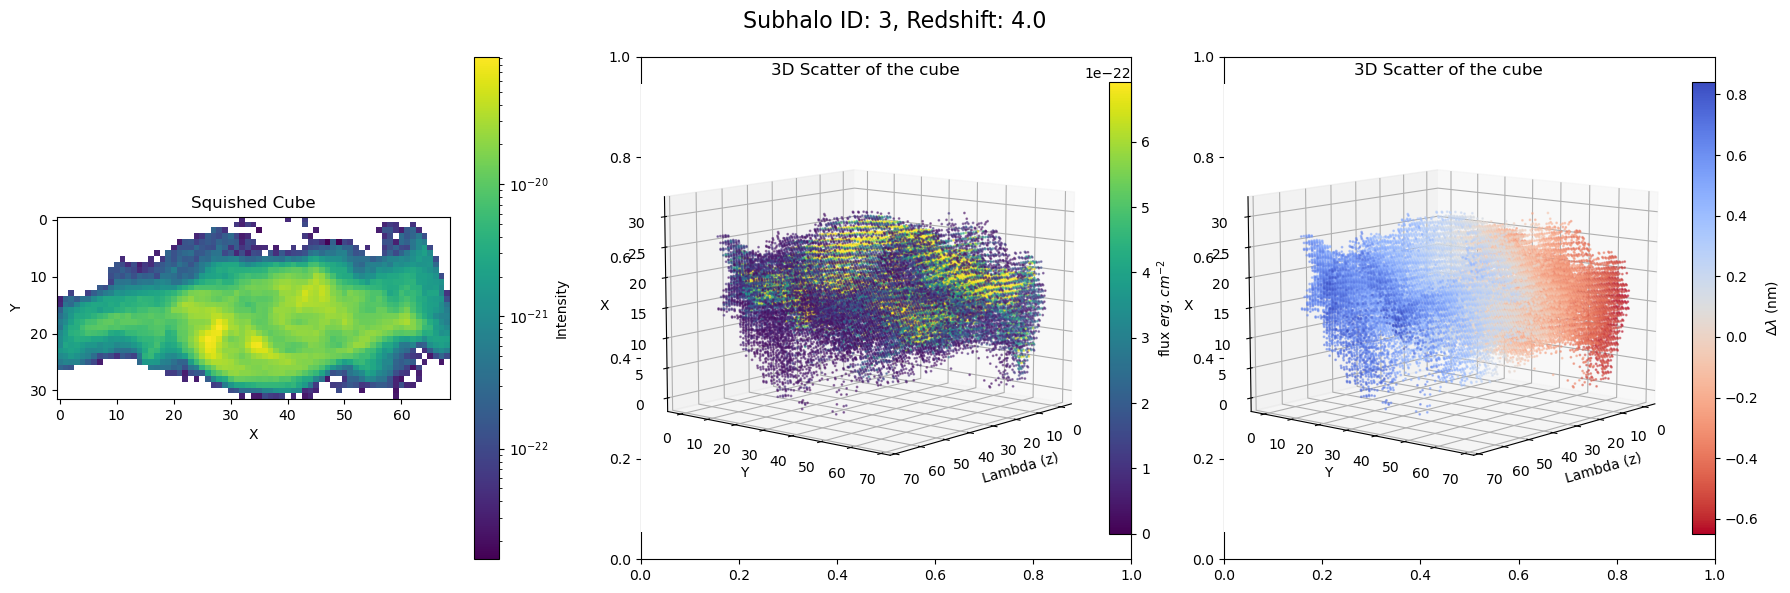

In [93]:
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Squished_cube on the left subplot
im = axes[0].imshow(Squished_cube, cmap='viridis',norm=LogNorm())
axes[0].set_title('Squished Cube')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].grid(False)
cbar1 = plt.colorbar(im, ax=axes[0], label='Intensity')  # Add a color bar to show the mapping of values to colors

# Plot 3D scatter plot of the cube on the middle subplot
axes[1] = fig.add_subplot(1, 3, 2, projection='3d')
x, y, z = np.nonzero(cube)
flux_cube = cube[x, y, z]  # Flux values

# Normalize the flux values for color mapping
norm = Normalize(vmin=0, vmax=np.percentile(cube[x, y, z], 80))

# Plot scatter points with colormap
scatter = axes[1].scatter(z, y, x, c=flux_cube, cmap='viridis', s=1, alpha=0.5, norm=norm)  # Swapping x and z here
axes[1].set_title('3D Scatter of the cube')
axes[1].set_xlabel('Lambda (z)')  # Swapped with x
axes[1].set_ylabel('Y')
axes[1].set_zlabel('X')  # Swapped with z

# Add color bar for the scatter plot
cbar2 = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axes[1], fraction=0.046, pad=0.04)
cbar2.set_label(r'flux $erg.cm^{-2}$')

# Adjusting the viewing angle
axes[1].view_init(elev=10, azim=40)

# Plot 3D scatter plot of the cube on the right subplot
axes[2] = fig.add_subplot(1, 3, 3, projection='3d')
x, y, z = np.nonzero(cube)

# Plot scatter points with colormap
norm2 = Normalize(vmin=np.min(Lambda), vmax=np.max(Lambda))

scatter = axes[2].scatter(z, y, x, c=z, cmap='coolwarm_r', s=1, alpha=0.5)  # Swapping x and z here
axes[2].set_title('3D Scatter of the cube')
axes[2].set_xlabel('Lambda (z)')  # Swapped with x
axes[2].set_ylabel('Y')
axes[2].set_zlabel('X')  # Swapped with z

# Add color bar for the scatter plot
cbar3 = fig.colorbar(cm.ScalarMappable(norm=norm2, cmap='coolwarm_r'), ax=axes[2], fraction=0.046, pad=0.04)
cbar3.set_label(r'$\Delta \lambda$ (nm)')

# Adjusting the viewing angle
axes[2].view_init(elev=10, azim=40)

# Add the main title
fig.suptitle(f'Subhalo ID: {ID}, Redshift: {Z:.1f}', fontsize=16)

plt.tight_layout()
plt.show()

In [2]:
(200/299792)*19693.8


13.138309227731225